# **Task #2 Machine Learning**

#### ***Made by Elizabeth Granda***

This is the second task for the ML course. For this task, the objective is to build a classification model to detect when a bank customer is about to leave the bank's services (churned or not churned).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import OneHotEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mutual_info_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
sns.set()

## **Exploratory Data Analysis**

In [ ]:
data = pd.read_csv("Bank Customer Churn Prediction.csv")
data.head()

customer_id  credit_score country  gender  age  tenure    balance  \
0     15634602           619  France  Female   42       2       0.00   
1     15647311           608   Spain  Female   41       1   83807.86   
2     15619304           502  France  Female   42       8  159660.80   
3     15701354           699  France  Female   39       1       0.00   
4     15737888           850   Spain  Female   43       2  125510.82   

   products_number  credit_card  active_member  estimated_salary  churn  
0                1            1              1         101348.88      1  
1                1            0              1         112542.58      0  
2                3            1              0         113931.57      1  
3                2            0              0          93826.63      0  
4                1            1              1          79084.10      0

In [ ]:
data.shape

(10000, 12)

In [ ]:
data.columns

Index(['customer_id', 'credit_score', 'country', 'gender', 'age', 'tenure',
       'balance', 'products_number', 'credit_card', 'active_member',
       'estimated_salary', 'churn'],
      dtype='object')

In [ ]:
# conteo de valores nulos > 0
nan_values = data.isna().sum()
columns_with_nans = nan_values[nan_values > 0]
columns_with_nans

Series([], dtype: int64)

In [ ]:
# buscando duplicados
data.loc[data.duplicated()]

Empty DataFrame
Columns: [customer_id, credit_score, country, gender, age, tenure, balance, products_number, credit_card, active_member, estimated_salary, churn]
Index: []

In [ ]:
# tipos de dato de nuestras variables
data.dtypes

customer_id           int64
credit_score          int64
country              object
gender               object
age                   int64
tenure                int64
balance             float64
products_number       int64
credit_card           int64
active_member         int64
estimated_salary    float64
churn                 int64
dtype: object

Since our problem is a classification task, specifically where the output is binary, we can quantitatively observe how many people are leaving the bank and how many are not.


In [ ]:
data.churn.value_counts()

churn
0    7963
1    2037
Name: count, dtype: int64

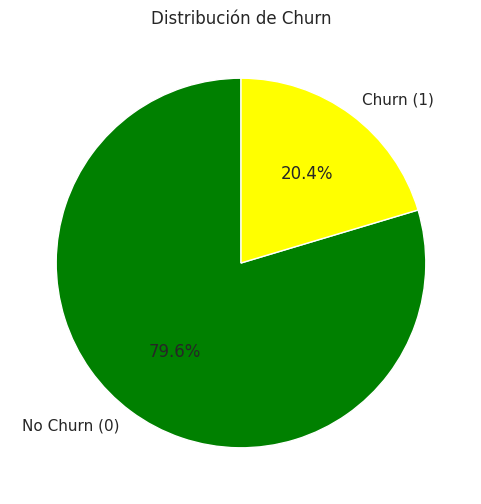

In [ ]:
churn_counts = data.churn.value_counts()
plt.figure(figsize=(6, 6))
plt.pie(churn_counts, labels=['No Churn (0)', 'Churn (1)'], autopct='%1.1f%%', startangle=90, colors=['green', 'yellow'])
plt.title('Distribución de Churn')
plt.show()

<Axes: >

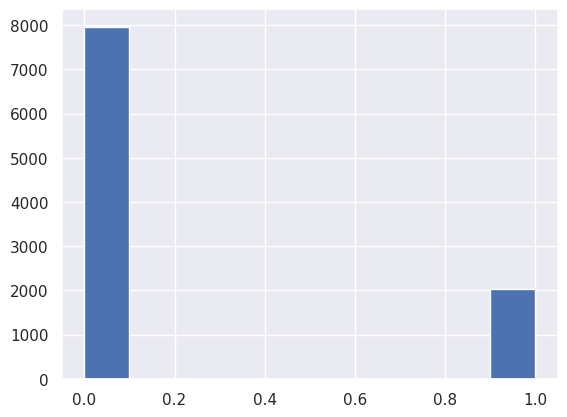

In [ ]:
# cantidad de personas que abandonan y que no abandonan
data.churn.hist()

### **Behavior of Numerical Variables**


<Axes: xlabel='credit_score', ylabel='Count'>

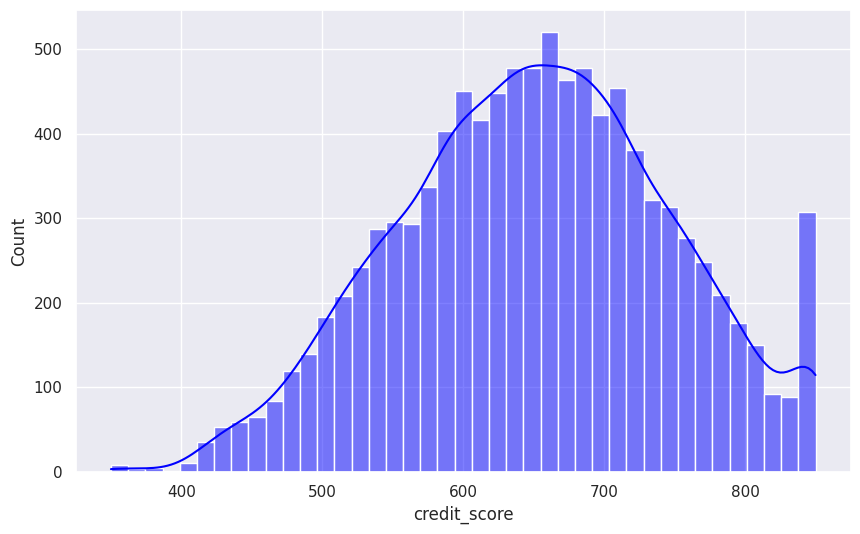

In [ ]:
# Distribucion de credit_score
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(data.credit_score, kde=True, ax=ax, color='blue')

<Axes: xlabel='age', ylabel='Count'>

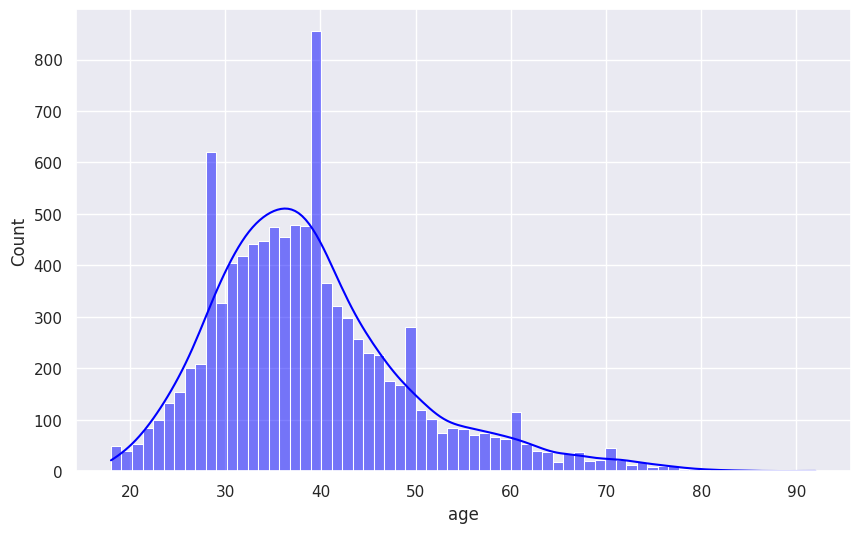

In [ ]:
# Distribucion de la edad
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(data.age, kde=True, ax=ax, color='blue')

<Axes: xlabel='balance', ylabel='Count'>

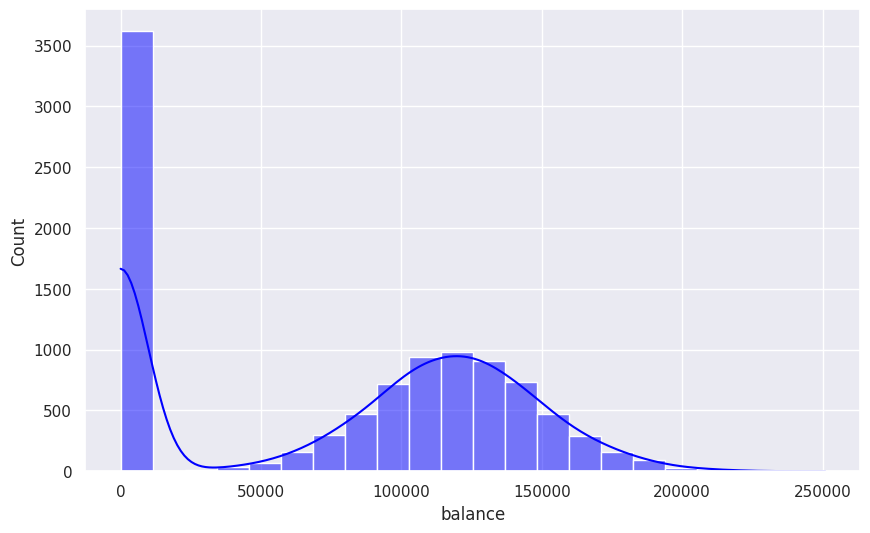

In [ ]:
# Distribucion de balance
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(data.balance, kde=True, ax=ax, color='blue')

Now let's observe how many people are leaving the bank based on country and gender (`country` and `gender` respectively). This will help us understand how much influence both categories have on the `churn` variable.


In [ ]:
# cuántos clientes han dejado el banco por país
df_churn = data[data['churn'] == 1]

country_churn = df_churn.groupby('country')['customer_id'].count().reset_index()
country_churn

country  customer_id
0   France          810
1  Germany          814
2    Spain          413

This tells us that we should pay attention to customers in Germany and France, as they are the ones leaving the bank in the highest numbers.


In [ ]:
# cuántos clientes han dejado el banco por genero
country_churn = df_churn.groupby('gender')['customer_id'].count().reset_index()
country_churn

gender  customer_id
0  Female         1139
1    Male          898

This information shows that women are leaving the bank at a significantly higher rate than men. Therefore, we could analyze the other binary and continuous variables in our dataset to identify behavioral patterns by gender. This could help inform decisions related to improvement plans, investment strategies, or savings programs based on the characteristics of each customer.


In [ ]:
min(data.age) #para saber de donde parten nuestros bins

18

In [ ]:
max(data.age) # hasta donde deben llegar los bins

92

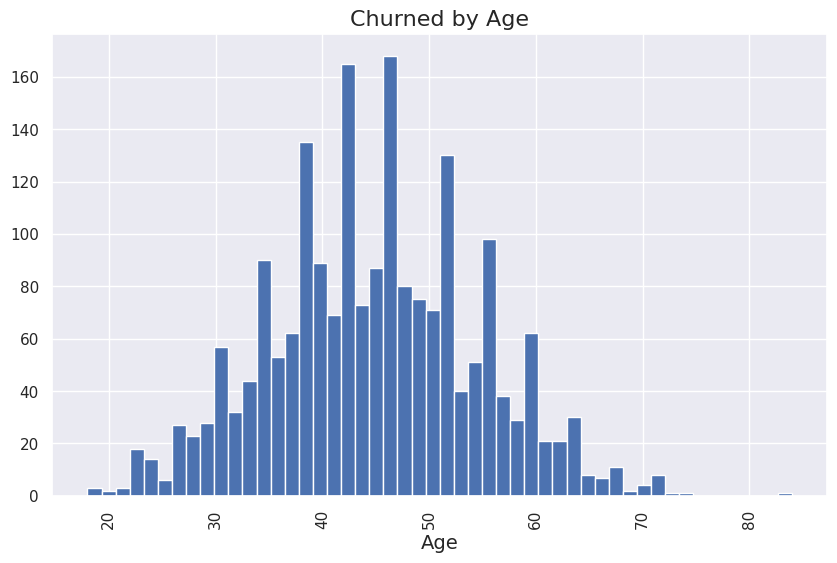

In [ ]:
# cuántos clientes han dejado el banco por edad
plt.figure(figsize=(10, 6))
df_churn.age.hist(bins=50)
plt.title('Churned by Age', fontsize=16)
plt.xlabel('Age', fontsize=14); plt.xticks(rotation=90)
plt.show()

This chart showing how many people leave the bank by age reveals a normal behavior. From this, we can conclude that age is a very important factor when assessing the risk of a customer leaving the bank. Special attention should be paid to people between the ages of 40 and 50, as this is where the highest concentration of departures occurs.

---

Taking a slightly different approach, we could ask: What is the average salary of people who leave the bank?



In [ ]:
average_salary_churn = df_churn['estimated_salary'].mean()
average_salary_churn

101465.67753068237

If we made a distinction by gender:


In [ ]:
average_salary_by_gender = df_churn.groupby('gender')['estimated_salary'].mean().reset_index()
average_salary_by_gender

gender  estimated_salary
0  Female     102948.986093
1    Male      99584.287272

This tells us that women who are leaving the bank earn, on average, slightly more than men, but it is not a very significant difference.

---

Now, we can perform a slightly different analysis between the features.

In the dataset, we have three continuous numerical variables, which are: `balance`, `credit_score`, and `estimated_salary`.

What we will do is observe the average behavior of the `credit_score` variable by country and by gender. This can be useful to observe, for example, in which cities around the world people are at more or less financial risk. A high percentage/value would indicate, for example, that the person is financially reliable.


In [ ]:
# paises contenidos en el dataset
data.country.value_counts()

country
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64

In [ ]:
def continous_var_behavior(feature1, feature2):
  avg_credit_score_by_country = data.groupby(feature1)[feature2].mean().reset_index()
  return avg_credit_score_by_country

In [ ]:
continous_var_behavior("country", "credit_score")

country  credit_score
0   France    649.668329
1  Germany    651.453567
2    Spain    651.333872

If we observe it in a general way, we can confirm this behavior:


Text(0.5, 1.0, 'Puntaje Crediticio por país')

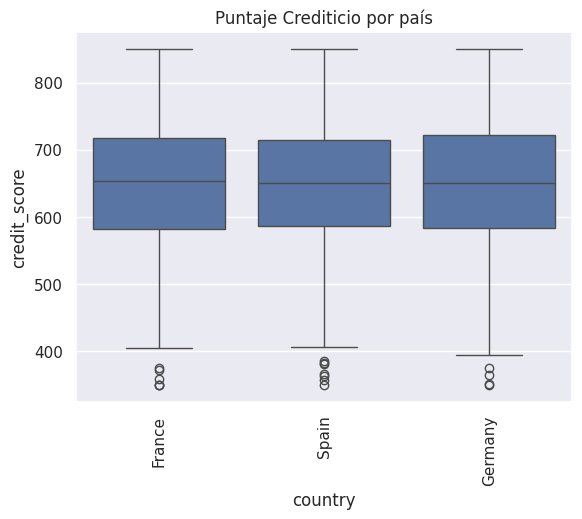

In [ ]:
sns.boxplot(x='country', y='credit_score', data=data)
plt.xticks(rotation=90); plt.title('Puntaje Crediticio por país')

Here we can see that on average, the credit score by country doesn't provide much information, as all the mean values are very similar.

Now, let's repeat this same analysis but with the gender variable:


In [ ]:
continous_var_behavior("gender", "credit_score")

gender  credit_score
0  Female    650.831389
1    Male    650.276892

What this tells us is that there is no distinction in financial risk by gender, meaning that, on average, men and women can have the same financial reliability.

---

Now, let's repeat this same analysis with the variables `balance` and `estimated_salary`. That is, we will observe the average account balance and estimated income by gender and country. This is:


In [ ]:
continous_var_behavior("gender", "balance")

gender       balance
0  Female  75659.369139
1    Male  77173.974506

On average, men have more money in their account than women. If we observe this behavior in general:


In [ ]:
max(data.balance) # para saber hasta donde llegan los bins

250898.09

<ipython-input-28-1d110a8111e9>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_data = data.groupby(['balance_bins', 'gender']).size().reset_index(name='count')


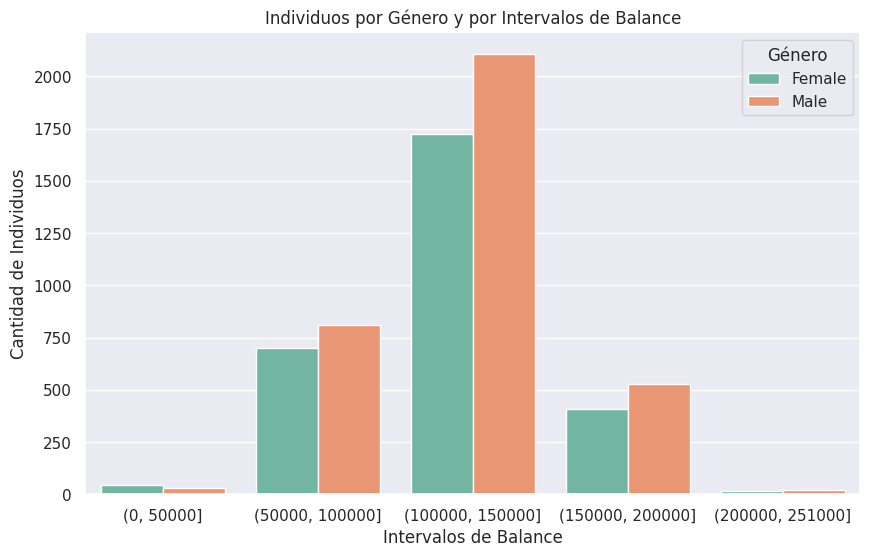

In [ ]:
bins = pd.cut(data['balance'], bins=[0, 50000, 100000, 150000, 200000, 251000])
data['balance_bins'] = bins

# cantidad de individuos por intervalo de balance y por género
count_data = data.groupby(['balance_bins', 'gender']).size().reset_index(name='count')
plt.figure(figsize=(10, 6))
sns.barplot(x='balance_bins', y='count', hue='gender', data=count_data, palette='Set2')
data.drop(columns=['balance_bins'], axis=1, inplace=True)
plt.title('Individuos por Género y por Intervalos de Balance')
plt.xlabel('Intervalos de Balance')
plt.ylabel('Cantidad de Individuos')
plt.legend(title='Género')
plt.show()

The graph reveals that most men and women have account balances between $100,000 and $150,000, with men predominating in this range. This trend could suggest that a higher proportion of men maintain higher balances compared to women. This information could be useful for the bank in making strategic decisions. For example, they might consider offering investment products or additional financial services aimed at customers within this balance range.

Now, we repeat the analysis but for the country:


In [ ]:
continous_var_behavior("country", "balance")

country        balance
0   France   62092.636516
1  Germany  119730.116134
2    Spain   61818.147763

Text(0.5, 1.0, 'Saldo por país')

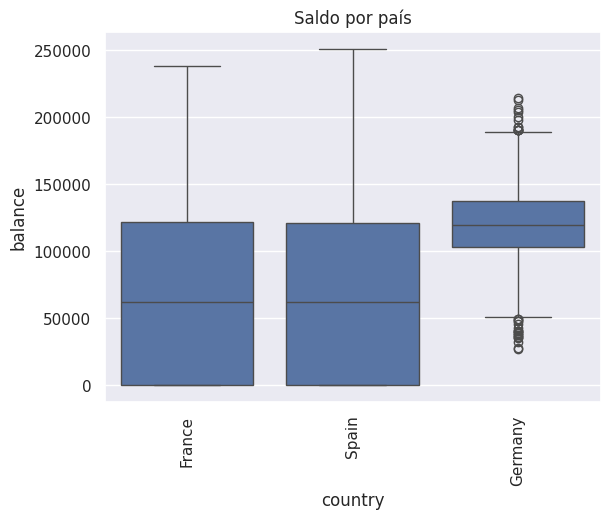

In [ ]:
sns.boxplot(x='country', y='balance', data=data)
plt.xticks(rotation=90); plt.title('Saldo por país')

This graph is very interesting and shows us that, for example, customers in Germany tend to have higher average balances in their accounts, and that none of the registered customers in the database have an account balance of $0, which implies a higher financial stability compared to customers from France and Spain.

---

Now, we repeat the analysis for `estimated_salary`:


In [ ]:
continous_var_behavior("gender", "estimated_salary")

gender  estimated_salary
0  Female     100601.541382
1    Male      99664.576931

Here we can see that the estimated salary for men and women shows practically no distinction. If we look at the behavior by country:


In [ ]:
continous_var_behavior("country", "estimated_salary")

country  estimated_salary
0   France      99899.180814
1  Germany     101113.435102
2    Spain      99440.572281

This doesn't tell us much either; the differences are minimal between countries. However, these salary differences could influence the decision to leave or stay with the bank. For example, clients in countries with higher salaries might have different expectations or financial behaviors compared to those in countries with lower average salaries.

---

Now, let's study the variables `active_member, credit_card, and products_number`. We can observe their behavior by gender and country. Additionally, it would be important to see how many products people who are leaving the bank usually have, and whether they were active members or had a credit card.

This analysis is:


In [ ]:
# cantidad de productos en general que tienen las personas
data.products_number.value_counts()

products_number
1    5084
2    4590
3     266
4      60
Name: count, dtype: int64

In [ ]:
# cantidad de productos pero por género
products_by_gender = data.groupby('gender')['products_number'].value_counts().reset_index(name='count')
products_by_gender

gender  products_number  count
0  Female                1   2296
1  Female                2   2060
2  Female                3    149
3  Female                4     38
4    Male                1   2788
5    Male                2   2530
6    Male                3    117
7    Male                4     22

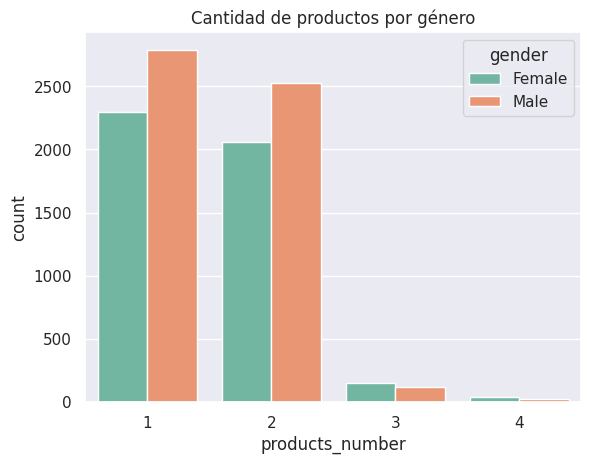

In [ ]:
# productos por genero
sns.barplot(x='products_number', y='count', hue='gender', data=products_by_gender, palette='Set2')
plt.title("Cantidad de productos por género")
plt.show()

Here we can see that a larger number of men, compared to women, tend to have between 1 and 2 products. However, if we observe the other numbers, we realize that although there are fewer women with 3 to 4 products, there are more women than men in this category.

Is there any relationship between the number of products and people who have left the bank? Let’s see:


In [ ]:
products_by_gender_churned = df_churn.groupby('gender')['products_number'].value_counts().reset_index(name='count')
products_by_gender_churned

gender  products_number  count
0  Female                1    762
1  Female                2    210
2  Female                3    129
3  Female                4     38
4    Male                1    647
5    Male                2    138
6    Male                3     91
7    Male                4     22

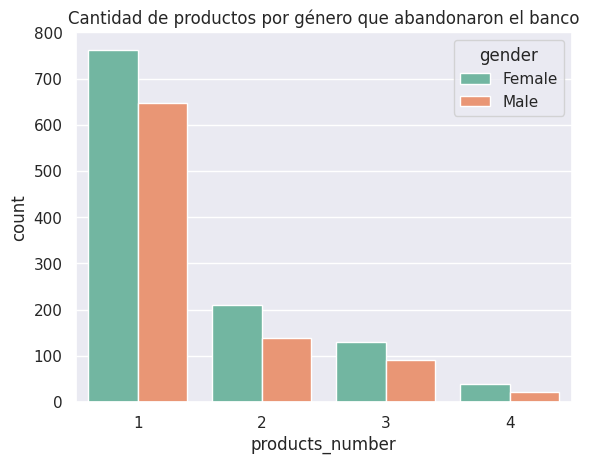

In [ ]:
sns.barplot(x='products_number', y='count', hue='gender', data=products_by_gender_churned, palette='Set2')
plt.title("Cantidad de productos por género que abandonaron el banco")
plt.show()

This aligns with what we showed earlier about the gender that leaves the bank more: it is women.

---

Now let's conduct a similar analysis, but this time with the feature `active_member`:


In [ ]:
# miembros activos
data.active_member.value_counts()

active_member
1    5151
0    4849
Name: count, dtype: int64

In [ ]:
# miembros activos por genero
active_member_by_gender = data.groupby('gender')['active_member'].value_counts().reset_index(name='count')
active_member_by_gender

gender  active_member  count
0  Female              1   2284
1  Female              0   2259
2    Male              1   2867
3    Male              0   2590

This doesn't provide much information. How many of these `active_member` have abandoned the bank? Considering that `active_member` refers more to how frequently a person used the bank's products, we could study the behaviors of people who left the bank. This is:


In [ ]:
active_member_by_gender_churned = df_churn.groupby('gender')['active_member'].value_counts().reset_index(name='count')
active_member_by_gender_churned

gender  active_member  count
0  Female              0    725
1  Female              1    414
2    Male              0    577
3    Male              1    321

Women were the ones who left the bank in greater numbers, and compared to men, they were more active with their products. This could be important for decision-making on strategies to prevent customer churn: knowing that the most active members are the ones leaving, I can develop plans that offer a financial horizon where staying is both affordable and stable.

---

We performed the same analysis for the `credit_card` feature.


In [ ]:
# personas con tarjeta de credito
data.credit_card.value_counts()

credit_card
1    7055
0    2945
Name: count, dtype: int64

Ahora por género:

In [ ]:
# personas con tarjeta de credito por genero
credit_card_by_gender = data.groupby('gender')['credit_card'].value_counts().reset_index(name='count')
credit_card_by_gender

gender  credit_card  count
0  Female            1   3192
1  Female            0   1351
2    Male            1   3863
3    Male            0   1594

Here we can see that men hold credit cards in higher numbers compared to women. How many of the people who have credit cards are leaving the bank?


In [ ]:
credit_card_by_gender_churned = df_churn.groupby('gender')['credit_card'].value_counts().reset_index(name='count')
credit_card_by_gender_churned

gender  credit_card  count
0  Female            1    795
1  Female            0    344
2    Male            1    629
3    Male            0    269

The same behavior observed with all the other features: women leave the bank significantly more than men.

---

Now, let's study the `tenure` variable, which refers to the length of time the customer has been with the bank, usually measured in years. This is:


<Axes: xlabel='tenure', ylabel='Count'>

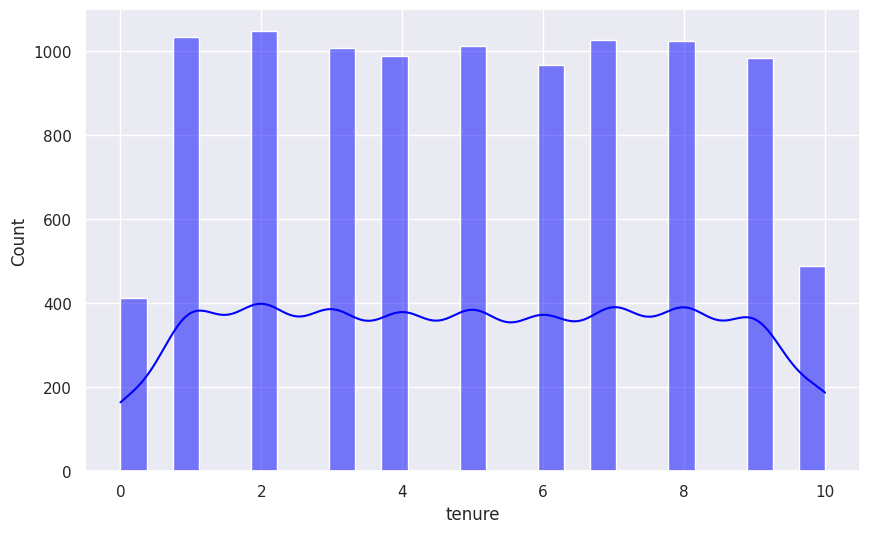

In [ ]:
# personas con tarjeta de credito
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(data.tenure, kde=True, ax=ax, color='blue')

In [ ]:
# antiguedad por genero
tenure_by_gender = data.groupby('gender')['tenure'].value_counts().reset_index(name='count')
tenure_by_country = data.groupby('country')['tenure'].value_counts().reset_index(name='count')

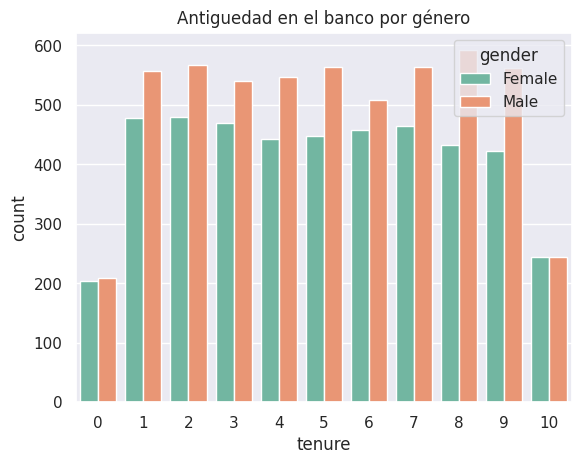

In [ ]:
sns.barplot(x='tenure', y='count', hue='gender', data=tenure_by_gender, palette='Set2')
plt.title("Antiguedad en el banco por género")
plt.show()

This tells us that a larger number of men, compared to women, tend to stay longer with the bank. The distinction between men and women doesn't really tell us much: a very noticeable pattern follows throughout the process, so it's likely that in a later step, when performing an analysis like mutual information, we will see that the `tenure` variable doesn't have much relevance in the model.


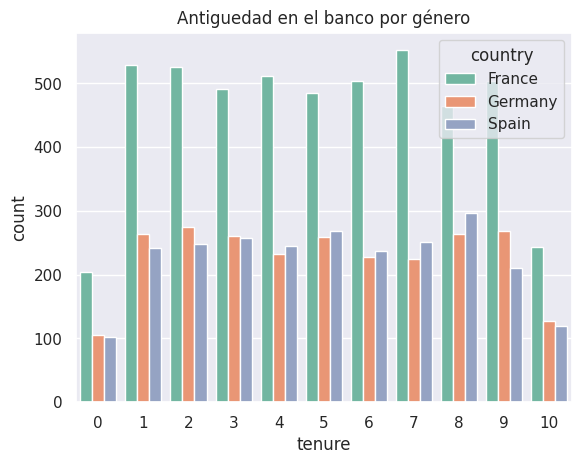

In [ ]:
#antiguedad por pais
sns.barplot(x='tenure', y='count', hue='country', data=tenure_by_country, palette='Set2')
plt.title("Antiguedad en el banco por género")
plt.show()

In this case, we can see that compared to other clients, customers from France tend to stay with the bank for a longer period of time. On the other hand, Germany and France show quite similar behavior, and it appears that the number of customers staying with the bank, regardless of the number of years, is almost always half of the total customers from France.


## **Starting the Model**

First, we split the data.


In [ ]:
df_full_train, df_test = train_test_split(data, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [ ]:
len(df_train), len(df_val), len(df_test), len(df_full_train)

(6000, 2000, 2000, 8000)

In [ ]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [ ]:
y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [ ]:
df_full_train = df_full_train.reset_index(drop=True)

---

#### **Behavior of Categorical Variables**

Previously, we didn't analyze the categorical variables since there are only two. The analysis for these can be more meaningful when we consider their representation in relation to the target variable. Let's observe this behavior:


In [ ]:
global_churn = data.churn.mean()
global_churn

0.2037

In [ ]:
string_type_cols = data.select_dtypes(include=['object'])
numerical_type_cols = data.select_dtypes(include=['number'])

In [ ]:
for c in string_type_cols:
    print(c)
    df_group = data.groupby(c).churn.agg(['mean', 'count'])
    df_group['diff'] = df_group['mean'] - global_churn
    df_group['risk'] = df_group['mean'] / global_churn
    display(df_group)
    print()
    print()

country


mean  count      diff      risk
country                                     
France   0.161548   5014 -0.042152  0.793067
Germany  0.324432   2509  0.120732  1.592695
Spain    0.166734   2477 -0.036966  0.818527



gender


mean  count      diff      risk
gender                                     
Female  0.250715   4543  0.047015  1.230807
Male    0.164559   5457 -0.039141  0.807851

We should remember that when the difference (`diff`) is negative, it indicates that "the group" represents the general population quite well. However, although these values are negative, they are very small. Therefore, to get a clearer picture, we can look at the `risk`, which measures the relationship between the average number of people who churn in that group and the overall average churn rate.

By observing the value of `risk`, we notice that Spain, for example, has a value close to 1. This means that the percentage of people churning in Spain is very similar to the overall churn percentage across the entire population. A `risk` value close to 1 indicates that this group behaves similarly to the general population, suggesting that the characteristics of people who churn in Spain are not particularly different from those of people in other countries.

On the other hand, when we look at other countries, like Germany for instance, we can see that it has a `risk` value greater than 1. This would indicate that, in that country, the churn rate is higher than the general average, meaning people in that country have a higher tendency to churn.

---

Now, we can perform **Mutual Information** for the 12 features in the dataset with respect to the target `churn`. This is:


In [ ]:
def mutual_info_saleprice_score(series):
    return mutual_info_score(series, df_full_train.churn)

In [ ]:
numerical_type_cols = df_train.select_dtypes(include=['number'])
mutual_info_obj = df_full_train[numerical_type_cols.columns.to_list()].apply(mutual_info_saleprice_score)
mutual_info_obj.sort_values(ascending=False)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)


customer_id         0.504191
estimated_salary    0.504191
balance             0.359386
age                 0.073488
products_number     0.069025
credit_score        0.034219
active_member       0.012872
tenure              0.000904
credit_card         0.000100
dtype: float64

### **Feature Engineering**

As observed in the EDA, the features that are continuous numeric variables in the dataset have quite a few outliers. For example, for the age (`age`) variable, the numbers range from 18 years to 92 years, and for the estimated salary (`estimated_salary`), the numbers range from $11.58 to $200,000. This shows that there are significant differences between the minimum and maximum values, and these extreme values are very few compared to the intermediate values between them.

The way we will handle this is as follows: We will discretize the `balance`, `estimated_salary`, `credit_score`, and `age` variables and then test the model.

This approach will involve discretizing these variables into groups. For age, we will create 6 groups: from 18 to 30 years, from 30 to 42 years, and so on, up to 92 years. Taking into account the minimum and maximum values of the other features mentioned in the previous paragraph, we will follow the same process to avoid having too many outliers, allowing the model to better fit the real data.

This is:


In [ ]:
bins = [18, 30, 42, 54, 66, 78, 92]
labels = [1, 2, 3, 4, 5, 6]

df_train['group_age'] = pd.cut(df_train['age'], bins=bins, labels=labels, right=True, include_lowest=True)
df_train.drop('age', axis=1, inplace=True)

df_test['group_age'] = pd.cut(df_test['age'], bins=bins, labels=labels, right=True, include_lowest=True)
df_test.drop('age', axis=1, inplace=True)

df_val['group_age'] = pd.cut(df_val['age'], bins=bins, labels=labels, right=True, include_lowest=True)
df_val.drop('age', axis=1, inplace=True)

df_full_train['group_age'] = pd.cut(df_full_train['age'], bins=bins, labels=labels, right=True, include_lowest=True)
df_full_train.drop('age', axis=1, inplace=True)

In [ ]:
bins = [0, 40000, 80000, 120000, 160000, 200000]
labels = [1, 2, 3, 4, 5]

df_train['group_estimated_salary'] = pd.cut(df_train['estimated_salary'], bins=bins, labels=labels, right=True, include_lowest=True)
df_train.drop('estimated_salary', axis=1, inplace=True)

df_test['group_estimated_salary'] = pd.cut(df_test['estimated_salary'], bins=bins, labels=labels, right=True, include_lowest=True)
df_test.drop('estimated_salary', axis=1, inplace=True)

df_val['group_estimated_salary'] = pd.cut(df_val['estimated_salary'], bins=bins, labels=labels, right=True, include_lowest=True)
df_val.drop('estimated_salary', axis=1, inplace=True)

df_full_train['group_estimated_salary'] = pd.cut(df_full_train['estimated_salary'], bins=bins, labels=labels, right=True, include_lowest=True)
df_full_train.drop('estimated_salary', axis=1, inplace=True)

In [ ]:
bins = [0, 40000, 80000, 120000, 160000, 202000, 250900]
labels = [1, 2, 3, 4, 5, 6]

df_train['group_balance'] = pd.cut(df_train['balance'], bins=bins, labels=labels, right=True, include_lowest=True)
df_train.drop('balance', axis=1, inplace=True)

df_full_train['group_balance'] = pd.cut(df_full_train['balance'], bins=bins, labels=labels, right=True, include_lowest=True)
df_full_train.drop('balance', axis=1, inplace=True)

df_test['group_balance'] = pd.cut(df_test['balance'], bins=bins, labels=labels, right=True, include_lowest=True)
df_test.drop('balance', axis=1, inplace=True)

df_val['group_balance'] = pd.cut(df_val['balance'], bins=bins, labels=labels, right=True, include_lowest=True)
df_val.drop('balance', axis=1, inplace=True)

In [ ]:
bins = [350, 400, 500, 600, 700, 800, 851]
labels = [1, 2, 3, 4, 5, 6]

df_train['group_credit_score'] = pd.cut(df_train['credit_score'], bins=bins, labels=labels, right=False, include_lowest=True)
df_train.drop('credit_score', axis=1, inplace=True)

df_test['group_credit_score'] = pd.cut(df_test['credit_score'], bins=bins, labels=labels, right=False, include_lowest=True)
df_test.drop('credit_score', axis=1, inplace=True)

df_val['group_credit_score'] = pd.cut(df_val['credit_score'], bins=bins, labels=labels, right=False, include_lowest=True)
df_val.drop('credit_score', axis=1, inplace=True)

df_full_train['group_credit_score'] = pd.cut(df_full_train['credit_score'], bins=bins, labels=labels, right=False, include_lowest=True)
df_full_train.drop('credit_score', axis=1, inplace=True)

It is important to note that in the next step, the feature values will be normalized. This is crucial in the case of binary classification and specifically for logistic regression. If the features are not normalized, those with larger scales will have larger weights, even if they are not necessarily more important.

Therefore, if we normalize all the features, our new data would look like this:


In [ ]:
def Normalize_Data_Min_Max(df):
  numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
  scaler = MinMaxScaler()

  df_normalized_numeric = scaler.fit_transform(df[numeric_cols])
  df_normalized_numeric = pd.DataFrame(df_normalized_numeric, columns=numeric_cols, index=df.index)
  df_categorical = df.drop(columns=numeric_cols) #mantenemos las categoricas
  df_normalized = pd.concat([df_normalized_numeric, df_categorical], axis=1) #formamos un nuevo dataframe normalizado
  return df_normalized

In [ ]:
df_full_train = Normalize_Data_Min_Max(df_full_train)
df_train = Normalize_Data_Min_Max(df_train)
df_val = Normalize_Data_Min_Max(df_val)
df_test = Normalize_Data_Min_Max(df_test)

<Axes: >

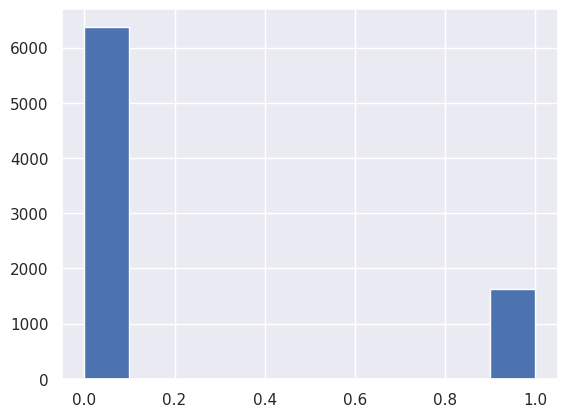

In [ ]:
df_full_train.churn.hist() #para ver que las proporciones de churn queden parecidas al "data", info original

Lo que haremos será descartar features que no nos aportan mucho al modelo. La primera que descartaremos será la variable `customer_id` ya que saber el codigo del cliente no me determinará si se irá o no del banco. Dado que hay tan pocas features ($12$) en total, descartarlas usando los criterios que se mostraron en el EDA podría llevar a un error, es decir, no estamos seguros de la relación concreta de algunas de las features con el target, entonces acudiremos al recurso visto en la clase sobre **árboles de desición**.

¿Para qué nos puede servir esto? Durante la construcción del árbol, se seleccionan las características que mejor dividen los datos en función de la métrica escogida lo que directamente puede usarse como clave para descartar features que no estén aportando de manera significativa al modelo.

Para poder lograr esto debemos tener nuestra data completamente de forma numérica. Para esto utilizaremos One Hot Encoding para las variables de `country` y `gender`. Para gender, el $1$ corresponderá a las mujeres.


 Esto lo podemos hacer con `scikit learn` de la siguiente forma:

In [ ]:
df_train = df_train.drop(columns=["customer_id"], axis=1)
df_train

tenure  products_number  credit_card  active_member  country  gender  \
0        0.7         0.000000          1.0            0.0   France  Female   
1        0.5         0.000000          1.0            0.0  Germany  Female   
2        0.6         0.000000          1.0            0.0  Germany  Female   
3        0.9         0.333333          1.0            1.0   France    Male   
4        0.1         0.000000          1.0            1.0  Germany    Male   
...      ...              ...          ...            ...      ...     ...   
5995     1.0         0.000000          1.0            1.0    Spain    Male   
5996     0.9         0.333333          1.0            0.0   France  Female   
5997     0.3         0.333333          1.0            0.0    Spain    Male   
5998     0.6         0.000000          1.0            0.0   France    Male   
5999     0.4         0.000000          1.0            0.0   France  Female   

     group_age group_estimated_salary group_balance group_credit_score  
0            2                      3             2                  5  
1            2                      5             2                  3  
2            2                      3             4                  5  
3            3                      2             1                  5  
4            1                      2             2                  4  
...        ...                    ...           ...                ...  
5995         2                      5             1                  6  
5996         2                      3             3                  6  
5997         4                      3             4                  5  
5998         2                      2             1                  4  
5999         3                      1             1                  3  

[6000 rows x 10 columns]

In [ ]:
def One_Hot_Encoding(df, column):
  encoder = OneHotEncoder(drop='first', sparse=False)  # 'drop=first' elimina la multicolinealidad
  encoded_gender = encoder.fit_transform(df[[column]])
  df_encoded = pd.DataFrame(encoded_gender, columns=encoder.get_feature_names_out([column]))
  df_final = pd.concat([df, df_encoded], axis=1)
  df_final = df_final.drop(columns=[column], axis=1)
  return df_final

In [ ]:
%%capture
df_full_train = One_Hot_Encoding(df_full_train, "country")
df_full_train = One_Hot_Encoding(df_full_train, "gender")

df_train = One_Hot_Encoding(df_train, "country")
df_train = One_Hot_Encoding(df_train, "gender")

df_test = One_Hot_Encoding(df_test, "country")
df_test = One_Hot_Encoding(df_test, "gender")

df_val = One_Hot_Encoding(df_val, "country")
df_val = One_Hot_Encoding(df_val, "gender")


We create the decision tree:

In [ ]:
#decision tree
predictors = df_full_train.columns.to_list()
predictors.remove('churn')
predictors.remove('customer_id')

target = df_full_train['churn']

tree = DecisionTreeClassifier(criterion='entropy', min_samples_split=20, max_depth=3, random_state=99)
tree.fit(df_full_train[predictors], target)

DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_split=20,
                       random_state=99)

In [ ]:
predictors

['tenure',
 'products_number',
 'credit_card',
 'active_member',
 'group_age',
 'group_estimated_salary',
 'group_balance',
 'group_credit_score',
 'country_Germany',
 'country_Spain',
 'gender_Male']

In [ ]:
df_test[predictors]

tenure  products_number  credit_card  active_member group_age  \
0        0.2         0.333333          1.0            1.0         3   
1        0.3         0.000000          1.0            0.0         2   
2        0.2         0.333333          0.0            1.0         2   
3        0.8         0.333333          0.0            1.0         2   
4        0.6         0.000000          1.0            1.0         1   
...      ...              ...          ...            ...       ...   
1995     0.7         0.333333          1.0            0.0         2   
1996     0.7         0.000000          0.0            0.0         3   
1997     1.0         0.333333          0.0            1.0         2   
1998     0.2         0.333333          1.0            1.0         1   
1999     0.9         0.000000          1.0            1.0         3   

     group_estimated_salary group_balance group_credit_score  country_Germany  \
0                         3             1                  3              0.0   
1                         2             4                  4              0.0   
2                         3             1                  3              0.0   
3                         1             4                  5              1.0   
4                         5             2                  3              1.0   
...                     ...           ...                ...              ...   
1995                      1             1                  5              0.0   
1996                      2             3                  6              0.0   
1997                      5             1                  3              0.0   
1998                      5             3                  4              1.0   
1999                      2             4                  4              1.0   

      country_Spain  gender_Male  
0               0.0          1.0  
1               0.0          1.0  
2               0.0          0.0  
3               0.0          1.0  
4               0.0          1.0  
...             ...          ...  
1995            1.0          0.0  
1996            0.0          0.0  
1997            1.0          1.0  
1998            0.0          0.0  
1999            0.0          1.0  

[2000 rows x 11 columns]

In [ ]:
preds = tree.predict(df_test[predictors])

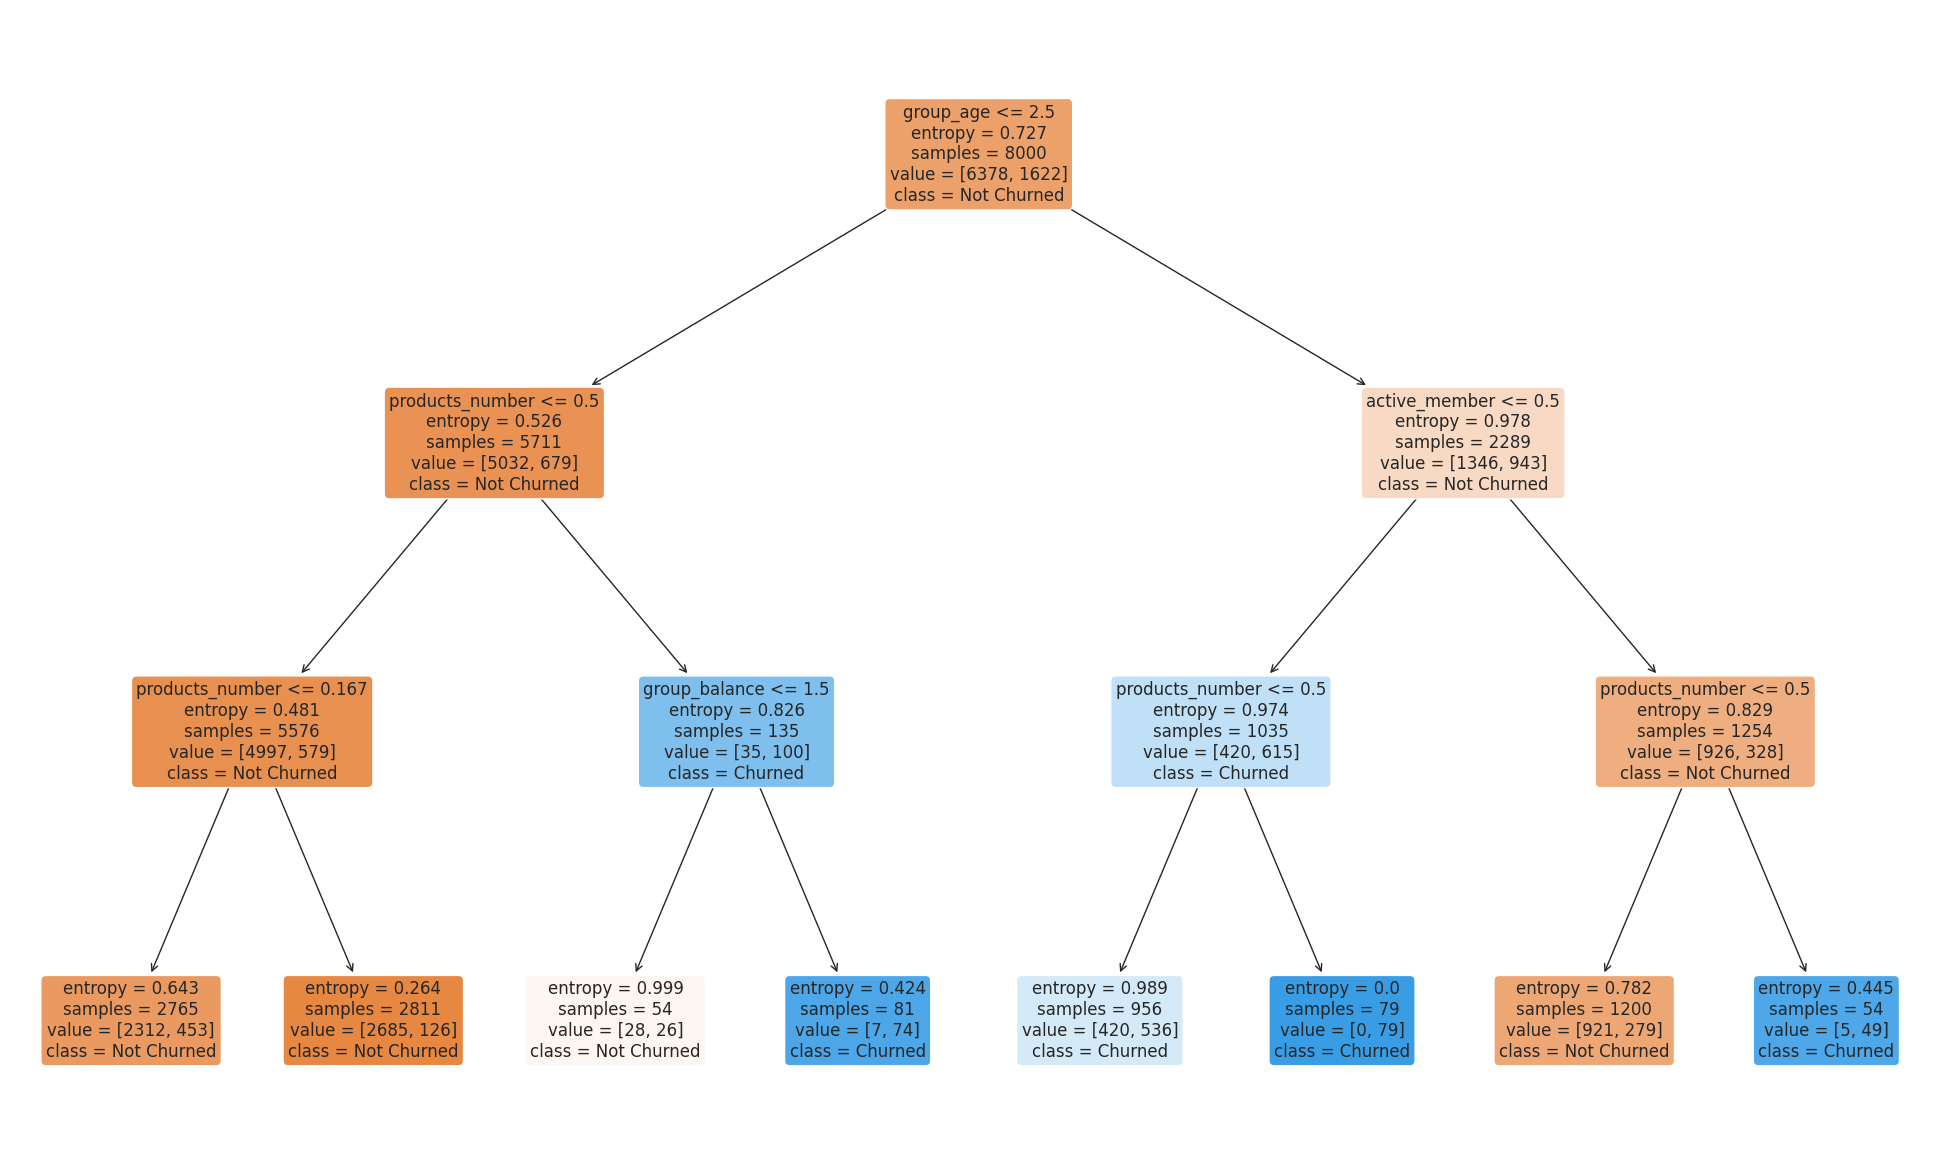

In [ ]:
plt.figure(figsize=(25, 15))
plot_tree(tree,
          feature_names=predictors,
          class_names=['Not Churned', 'Churned'],
          rounded=True,
          filled=True,
          fontsize=12)

plt.show()

The information provided by mutual information is a bit different from what a decision tree provides. This may be because **mutual information captures non-linear and not necessarily hierarchical relationships**. It detects any type of dependency, meaning it can identify complex relationships that other methods cannot.

On the other hand, a **decision tree selects the variable that best separates the classes or target values at each node**. At each level of the tree, the variable that maximizes the reduction of impurity by dividing the dataset into more homogeneous subsets is chosen.

---
In this decision tree, we can see that the most important feature for determining whether a customer leaves the bank or not is the `age` feature. Followed by this are the features `products_number` and `active_member`. Therefore, we will take these into account when building the logistic regression model.

---
Having this, we can now start our model with Logistic Regression implemented in `scikit-learn`.

## **Model Implementation**

Now we'll look at a correlation matrix with the variables we'll use in the model. As mentioned before, this is important to avoid overfitting or the data fitting too well to the training set and not performing very well on the test set.

The **Feature Engineering** part was done in a previous process when we created the decision tree, where we performed One Hot Encoding on the categorical variables `country` and `gender`. One Hot Encoding works quite well in this case since both features have few categories, $3$ and $2$ respectively, so it's optimal to do it this way.

Our correlation matrix then looks like this:

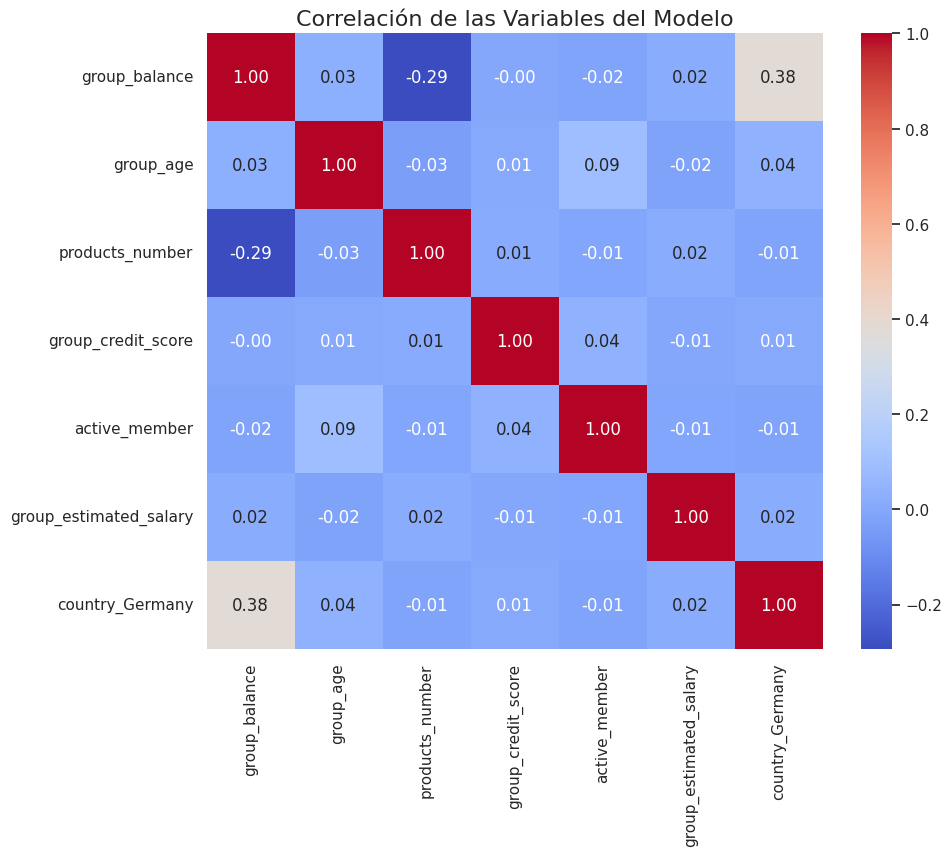

In [ ]:
selected_columns = ["group_balance", "group_age", "products_number", "group_credit_score" ,
                    "active_member", "group_estimated_salary", "country_Germany"]

df_selected = df_train[selected_columns]
corr_matrix = df_selected.corr(method='pearson')

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', square=True, annot=True, fmt=".2f")
plt.title('Correlación de las Variables del Modelo', fontsize=16)
plt.show()

### **Logistic Regression Model**

In [ ]:
len(selected_columns) #con cuantas features haremos modelo

7

In [ ]:
model_1 = LogisticRegression()

X_train = df_train[selected_columns]
X_test = df_test[selected_columns]
X_val = df_val[selected_columns]
model_1.fit(X_train, y_train)

LogisticRegression()

In [ ]:
model_1.intercept_[0]

-3.0231420426884914

In [ ]:
model_1.coef_[0].round(3)

array([ 0.09 ,  0.8  , -0.205, -0.064, -1.021,  0.013,  0.727])

In [ ]:
y_pred_1 = model_1.predict_proba(X_val)[:, 1]
y_pred_1

array([0.08678188, 0.2907422 , 0.10533602, ..., 0.24481197, 0.0371844 ,
       0.09536789])

In [ ]:
churn_decision = (y_pred_1 >= 0.2)
(y_val == churn_decision).mean()

0.7015

The variable `churn_decision` is a binary prediction of whether or not the customer will churn, determined by whether the predicted probability (`y_pred_1`) exceeds the threshold of $0.2$. This threshold was chosen to be so low because if it is chosen as $0.5$ or more, this standard threshold is biased by the imbalance of the data, leading to inconclusive answers. By reducing this threshold, the model predicts "churn" more frequently, which increases the true positive rate (Recall), although it could also increase false positives. In this case, that value is $0.70$.

In [ ]:
print("**********Scores y resultados para Regresión Logística Data de Validación**********")
accuracy = accuracy_score(y_val, model_1.predict(X_val))
print(f'Accuracy: {accuracy:.2f}')
precision = precision_score(y_val, model_1.predict(X_val))
print(f'Precision: {precision:.2f}')
recall = recall_score(y_val, model_1.predict(X_val))
print(f'Recall: {recall:.2f}')
f1 = f1_score(y_val, model_1.predict(X_val))
print(f'F1 Score: {f1:.2f}')

**********Scores y resultados para Regresión Logística Data de Validación**********
Accuracy: 0.81
Precision: 0.61
Recall: 0.21
F1 Score: 0.31


In [ ]:
print("**********Scores y resultados para Regresión Logística Data de Testeo**********")
accuracy = accuracy_score(y_test, model_1.predict(X_test))
print(f'Accuracy: {accuracy:.2f}')
precision = precision_score(y_test, model_1.predict(X_test))
print(f'Precision: {precision:.2f}')
recall = recall_score(y_test, model_1.predict(X_test))
print(f'Recall: {recall:.2f}')
f1 = f1_score(y_test, model_1.predict(X_test))
print(f'F1 Score: {f1:.2f}')

**********Scores y resultados para Regresión Logística Data de Testeo**********
Accuracy: 0.82
Precision: 0.67
Recall: 0.24
F1 Score: 0.35


Metrics give us information about whether the model is good (predicts correctly and effectively who will leave the bank) or not. But depending on the context of the problem, we need to know which metric matters most to us.

In this case, a metric like **accuracy** can be misleading because the dataset is imbalanced, that is, there are many more people who don't leave compared to those who do. A model that simply predicts that no one will leave could have a high **accuracy** but wouldn't be useful in practice because it wouldn't be identifying the customers who actually leave. This is exactly what's happening here, as we can see by analyzing the other metrics that the people who are actually leaving are not being predicted well.

The **Recall** metric measures, in this case, how many of the customers who actually left the bank (true positives) were correctly identified by the model. That's why this is the most concerning value. A recall of 21% means that the model is only correctly identifying 21% of the customers who actually leave the bank and is missing 79% of the customers who are leaving, which translates into losses for the bank.

**Precision** measures how many of those that the model predicted would leave actually did. It's only doing this 46.1% of the time.

Finally, and one of the most important metrics, is the **F1-score** which is the balance between precision and recall. If we have a scenario where both correctly detecting churn cases and avoiding false positives are important, the F1-score is the most representative metric.



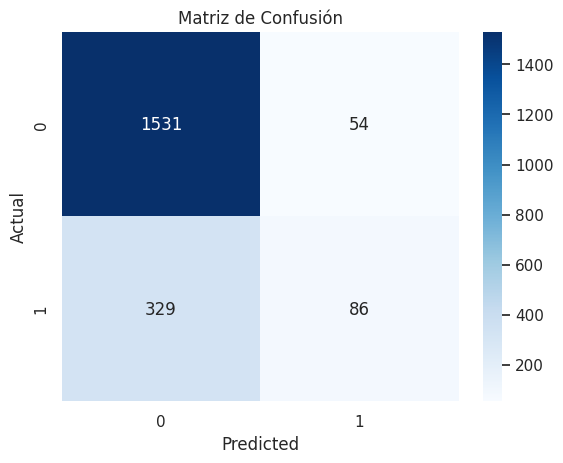

In [ ]:
# matriz de confusion
cm = confusion_matrix(y_val, model_1.predict(X_val))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')
plt.show()


To better understand the image provided by the confusion matrix, let's explain what each of the numbers represents.

* The $1531$ tells us about the **True Negatives**, which is the number of times the model correctly predicted that customers **will not churn**.
* The $54$ refers to the **False Positives**, which is the number of times the model incorrectly predicted that customers will churn (positive class), when in reality they did not churn.
* The $329$ refers to the **False Negatives**, which is the number of times the model incorrectly predicted that customers will not churn, but in reality they did churn.
* Finally, the $86$ refers to the **True Positives**, which is the number of times the model correctly predicted that customers will churn (positive class).
* The parameter that concerns us most is the last one, so we see that the model is actually predicting very little about this.

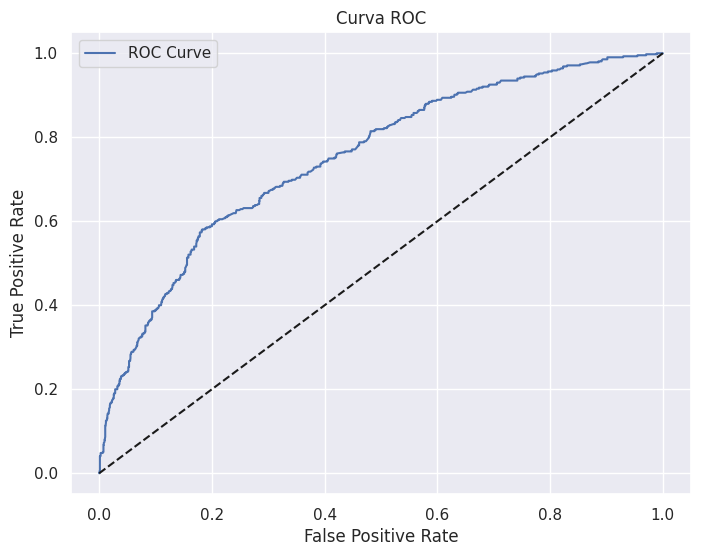

In [ ]:
# curva ROC
fpr, tpr, thresholds = roc_curve(y_val, y_pred_1)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend()
plt.show()


### **Random Forest Model**

In [ ]:
# random forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy Validation Dataset: {accuracy:.4f}")
print(classification_report(y_val, y_pred, target_names=['Not Churned', 'Churned']))
y_pred_proba = rf_model.predict_proba(X_val)[:, 1]

Accuracy Validation Dataset: 0.8285
              precision    recall  f1-score   support

 Not Churned       0.87      0.93      0.90      1585
     Churned       0.62      0.45      0.52       415

    accuracy                           0.83      2000
   macro avg       0.74      0.69      0.71      2000
weighted avg       0.81      0.83      0.82      2000



The Random Forest model improves significantly: the recall and F1-score, which are the most important metrics for the context of the exercise, increase considerably. They are still quite low but are much better compared to the logistic regression model.

### **A Model with Resampling (Undersampling)**

What if we tried to reduce the data of people who stayed (churn = $0$) and compensate a bit for the data of the people who left? This is just to test how the model would behave by checking it with the test and validation data.

**How does Undersampling work?** It reduces the size of the majority class by selecting a smaller sample of its examples. The goal is to make the number of examples in the majority class closer to that of the minority class, although not necessarily equal.

In this case, we will use the `RandomUnderSampler` function, which is a sampling technique that reduces the number of examples of the majority class by randomly selecting some examples from that class to create a balance with the minority class.

The way it works is as follows: the function receives two parameters, one called `sampling_strategy` which is a parameter that specifies the proportion of the majority class that should be retained after undersampling. In this case, we will say that the majority class should be $0.7$ times the total size of the minority class. That is, if the minority class has $100$ examples, the majority class will be reduced to $70$ examples. The other parameter is the `random_state`, which is used for many other functions and simply serves as a seed so that we get the same dataset each time the code is run.

The first graph from left to right graphically explains what Undersampling consists of:

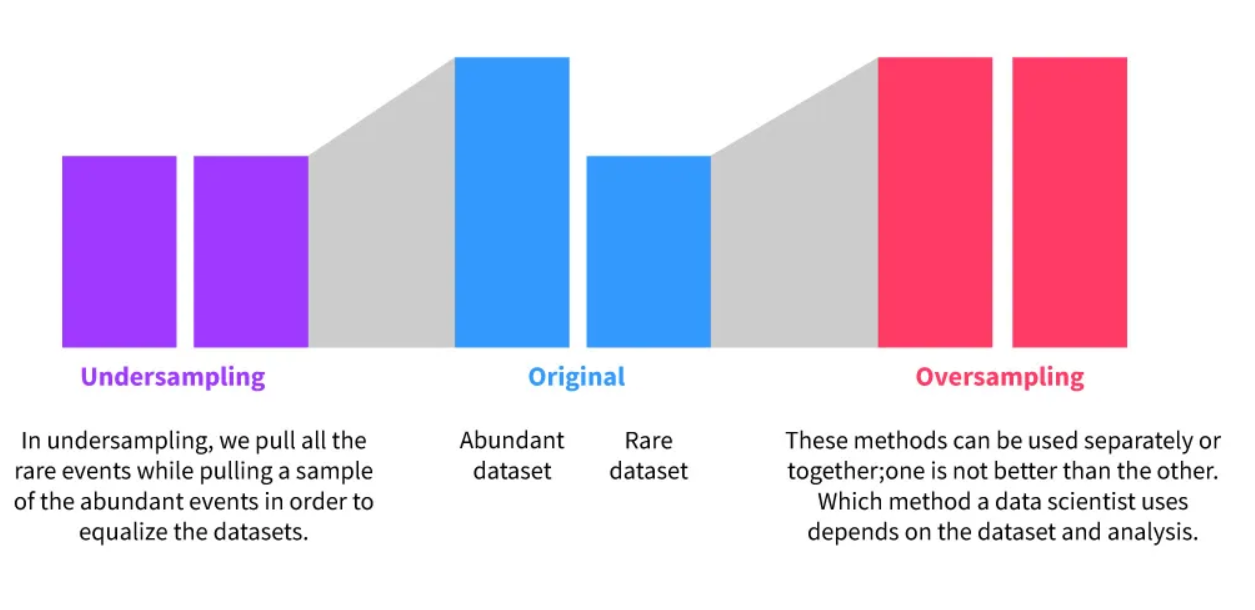

Applying this, we have the next results:

Len UnderSampling Data Train: 2931


**********Scores y resultados para Regresión Logística con UnderSampling Data de Validación**********
Accuracy Validation Data: 0.75
Precision Validation Data: 0.43
Recall Validation Data: 0.59
F1 Score Validation Data: 0.50


**********Scores y resultados para Regresión Logística con UnderSampling Data de Testeo**********
Accuracy Test Data: 0.77
Precision Test Data: 0.45
Recall Test Data: 0.60
F1 Score Test Data: 0.52


ROC Curve


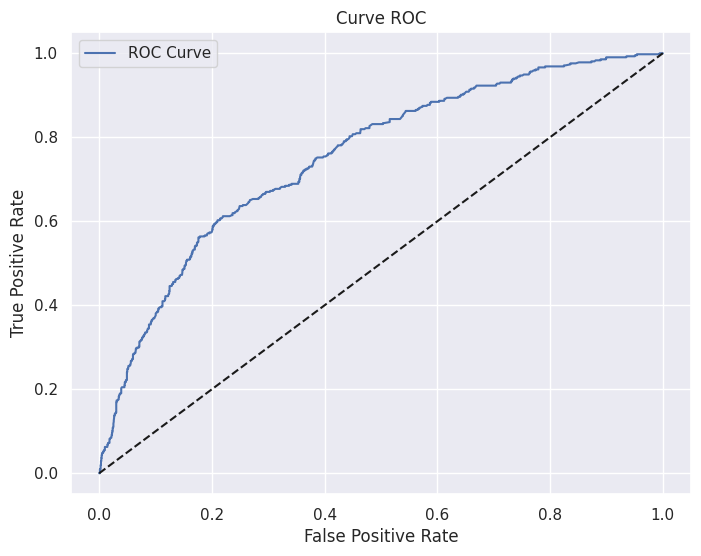

In [ ]:
# @title **Regresión Logística con UnderSampling**
y_train_series = pd.Series(y_train)

undersample = RandomUnderSampler(sampling_strategy=0.7, random_state=1)
X_train_undersample, y_train_undersample = undersample.fit_resample(X_train, y_train_series)
model_2 = LogisticRegression()
model_2.fit(X_train_undersample, y_train_undersample) #logistic regression
y_pred_under = model_2.predict_proba(X_val)[:, 1]

print(f"Len UnderSampling Data Train: {len(X_train_undersample)}") # longitud de la nueva data de entrenamiento
print()
print()
print("**********Scores y resultados para Regresión Logística con UnderSampling Data de Validación**********")
accuracy = accuracy_score(y_val, model_2.predict(X_val))
print(f'Accuracy Validation Data: {accuracy:.2f}')
precision = precision_score(y_val, model_2.predict(X_val))
print(f'Precision Validation Data: {precision:.2f}')
recall = recall_score(y_val, model_2.predict(X_val))
print(f'Recall Validation Data: {recall:.2f}')
f1 = f1_score(y_val, model_2.predict(X_val))
print(f'F1 Score Validation Data: {f1:.2f}')

print(  )
print(  )


print("**********Scores y resultados para Regresión Logística con UnderSampling Data de Testeo**********")
accuracy = accuracy_score(y_test, model_2.predict(X_test))
print(f'Accuracy Test Data: {accuracy:.2f}')
precision = precision_score(y_test, model_2.predict(X_test))
print(f'Precision Test Data: {precision:.2f}')
recall = recall_score(y_test, model_2.predict(X_test))
print(f'Recall Test Data: {recall:.2f}')
f1 = f1_score(y_test, model_2.predict(X_test))
print(f'F1 Score Test Data: {f1:.2f}')

print()
print()
print("ROC Curve")

fpr, tpr, thresholds = roc_curve(y_val, y_pred_under)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curve ROC')
plt.legend()
plt.show()

 What if we try our data with Undersampling using RandomForest?

 Let's see how the metrics look in this case:

In [ ]:
# @title **Random Forest con UnderSampling**

rf_model_2 = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_2.fit(X_train_undersample, y_train_undersample)
y_pred_2 = rf_model_2.predict(X_val)

accuracy = accuracy_score(y_val, y_pred_2)
print(f"Accuracy Validation Dataset: {accuracy:.4f}")
print(classification_report(y_val, y_pred_2, target_names=['Not Churned', 'Churned']))
y_pred_proba = rf_model_2.predict_proba(X_val)[:, 1]

print()
print("***********************************")
print()

y_pred_2_ = rf_model_2.predict(X_test)
accuracy_ = accuracy_score(y_test, y_pred_2)
print(f"Accuracy Test Dataset: {accuracy_:.4f}")
print(classification_report(y_test, y_pred_2_, target_names=['Not Churned', 'Churned']))
y_pred_proba = rf_model_2.predict_proba(X_test)[:, 1]

Accuracy Validation Dataset: 0.7805
              precision    recall  f1-score   support

 Not Churned       0.89      0.82      0.86      1585
     Churned       0.48      0.63      0.54       415

    accuracy                           0.78      2000
   macro avg       0.69      0.72      0.70      2000
weighted avg       0.81      0.78      0.79      2000


***********************************

Accuracy Test Dataset: 0.6285
              precision    recall  f1-score   support

 Not Churned       0.91      0.84      0.87      1585
     Churned       0.53      0.67      0.59       415

    accuracy                           0.81      2000
   macro avg       0.72      0.76      0.73      2000
weighted avg       0.83      0.81      0.82      2000



### **A Model with Class Weights**

To adjust the class weights in a model working with imbalanced data, as in this case where class $0$ is much more frequent than class $1$, the goal of assigning different weights to the classes is to penalize errors in the minority class (class 1) more. This forces the model to pay more attention to the observations of that class. But how are the class weights determined?

The most common way is the **inverse proportion of class size**, which consists of setting the weights inversely proportional to the size of the classes. This will give more weight to the minority class. It is represented as follows:

$$Weight_{class_{1}} = \frac{1} {\text{size of class 1}}$$

$$Weight_{class_{0}} = \frac{1} {\text{size of class 0}}$$

$$\text {Ratio} = \frac{\text{4793}}{1207} \approx 4$$

So, weights like `{0: 1, 1: 4}` could be used. This indicates that an error in class 1 is four times more important than an error in class 0.

This looks like the following:

In [ ]:
pd.Series(y_train).value_counts() #para la razon

0    4793
1    1207
Name: count, dtype: int64

**********Scores y resultados para Regresión Logística con Pesos Data de Validación**********
Accuracy: 0.72
Precision: 0.39
Recall: 0.64
F1 Score: 0.49
**********Scores y resultados para Regresión Logística con Pesos Data de Testeo**********
Accuracy: 0.73
Precision: 0.40
Recall: 0.64
F1 Score: 0.50
ROC Curve


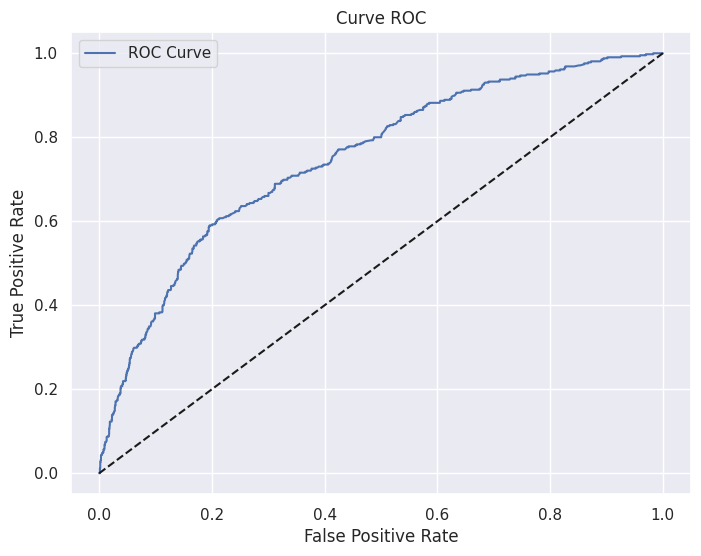

In [ ]:
# @title **Regresión Logística con Pesos**
class_weights = {0: 1, 1: 4}  # ajusta los pesos segun la proporcion de las clases
lr_weight = LogisticRegression(class_weight=class_weights, random_state=1)

lr_weight.fit(X_train, y_train)
y_pred_lr_weight = lr_weight.predict_proba(X_val)[:, 1]


print("**********Scores y resultados para Regresión Logística con Pesos Data de Validación**********")
accuracy = accuracy_score(y_val, lr_weight.predict(X_val))
print(f'Accuracy: {accuracy:.2f}')
precision = precision_score(y_val, lr_weight.predict(X_val))
print(f'Precision: {precision:.2f}')
recall = recall_score(y_val, lr_weight.predict(X_val))
print(f'Recall: {recall:.2f}')
f1 = f1_score(y_val, lr_weight.predict(X_val))
print(f'F1 Score: {f1:.2f}')

print("**********Scores y resultados para Regresión Logística con Pesos Data de Testeo**********")
accuracy = accuracy_score(y_test, lr_weight.predict(X_test))
print(f'Accuracy: {accuracy:.2f}')
precision = precision_score(y_test, lr_weight.predict(X_test))
print(f'Precision: {precision:.2f}')
recall = recall_score(y_test, lr_weight.predict(X_test))
print(f'Recall: {recall:.2f}')
f1 = f1_score(y_test, lr_weight.predict(X_test))
print(f'F1 Score: {f1:.2f}')

print("ROC Curve")

fpr, tpr, thresholds = roc_curve(y_val, y_pred_lr_weight)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curve ROC')
plt.legend()
plt.show()

This indicates an increase in recall, which can also be interpreted as overfitting to class $1$.

In [ ]:
# @title **Random Forest con Pesos**

rf_model_wei = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_wei.fit(X_train, y_train)
y_pred_wei = rf_model_wei.predict(X_val)

accuracy = accuracy_score(y_val, y_pred_wei)
print(f"Accuracy Validation Dataset: {accuracy:.4f}")
print(classification_report(y_val, y_pred_wei, target_names=['Not Churned', 'Churned']))
y_pred_proba = rf_model_wei.predict_proba(X_val)[:, 1]

print()
print("***********************************")
print()

y_pred_wei = rf_model_wei.predict(X_test)
accuracy_ = accuracy_score(y_test, y_pred_wei)
print(f"Accuracy Test Dataset: {accuracy_:.4f}")
print(classification_report(y_test, y_pred_wei, target_names=['Not Churned', 'Churned']))
y_pred_proba = rf_model_wei.predict_proba(X_test)[:, 1]

Accuracy Validation Dataset: 0.8285
              precision    recall  f1-score   support

 Not Churned       0.87      0.93      0.90      1585
     Churned       0.62      0.45      0.52       415

    accuracy                           0.83      2000
   macro avg       0.74      0.69      0.71      2000
weighted avg       0.81      0.83      0.82      2000


***********************************

Accuracy Test Dataset: 0.8465
              precision    recall  f1-score   support

 Not Churned       0.88      0.94      0.91      1585
     Churned       0.68      0.50      0.57       415

    accuracy                           0.85      2000
   macro avg       0.78      0.72      0.74      2000
weighted avg       0.84      0.85      0.84      2000



**Conclusions**

* The metrics resulting from model number 1 with logistic regression show us not very good results. If we look at the accuracy metric for example, we will see a fairly acceptable number of 0.81, but it is very important to bear in mind that in this case the data is highly imbalanced, that is, there is a lot of information about people who stay in the bank (≈ 80%) and very little about the data that really matters to us and which we want to attack: the people who leave (≈ 20%) because it is the reality of what happens. This leads to the mistake of predicting with high precision who are staying in the bank instead of studying who are leaving. So in this case, the metrics that are given more value and/or importance are the recall and the f1-score. Both metrics told us how many people were leaving the bank and we were predicting correctly (True Positives). The f1-score better reflects the performance of the model in the minority class and is the balance between precision and recall, when the value of this metric is close to 1, it indicates that both precision and recall are high, which means that the model has a good balance between correctly predicting the positives and finding them. That is why different models with different approaches to the solution were tested: it was desired to test which one gave better results in these two metrics specifically. 

* The model with Random Forest shows a significant improvement in all metrics. The metrics that we should give the most importance to, which are recall and f1 score, show us an improvement of 0.22 and 0.20 respectively for the model compared to the results of model 1 with logistic regression, which in turn implies that the model is much better at predicting the people who will actually leave the bank (recall) and show us a better balance between precision and recall.

* In model number two with logistic regression that we tested, where we used UnderSampling, it shows us much better results compared to model 1 of RL and Random Forest that we used. However, it is important to keep in mind that by reducing the number of examples of the majority class, data that could be important and useful for the learning of the model is eliminated, that is, biases are created. If the removed examples contain relevant patterns, the model may suffer in terms of accuracy and generalization. For our case, that undersampling reduced in some way the overfitting on class 0 that was existing in model 1 and the recall and precision were reduced for this class and increased for the other (1) significantly but not exaggerated, which could mean that this undersampling was a good decision :) (but I'm not sure).

* In model number two with Random Forest (with UnderSampling) we saw a very significant improvement compared to all the previous ones!! The recall with the test data gave us a result of 0.67, which is a better result than with the validation data (0.63), which tells us how the model is generalizing quite a bit when it comes to evaluating who really leaves the bank.

* Finally, the imbalance of the data was attacked in another way: by assigning weights to each of the classes. Doing this has several disadvantages, like UnderSampling. Determining the correct weights can be quite a challenge and doing it wrong can lead to overfitting in the minority class (creation of false positives). Assigning weights to the classes can improve metrics such as recall for the minority class, but other metrics such as precision or the f1-score could be negatively affected. If the weight is poorly balanced, the model may predict the minority class more frequently, but increase errors in general. In the case of the results given by the model, we have that effectively the recall improves quite a bit compared to all previous models but the f1-score decreases if we compare it with the undersampling model for example. This tells us about an imbalance between precision and recall, so perhaps false positives are being created. The random forest teaches us the same thing although with an improvement in the value of precision, which in turn improves the value of the f1-score.

* I think that if the model had a little more features or more significant features that provided more financial information about the customer, the model could improve significantly.

* In case UnderSampling is valid for this classification problem, this would be the model I would use to predict the people who stay or leave the bank. Its results in recall, precision, and f1-score show that it is a good option compared to the other models that were implemented. In addition, it is shown that the values of the metrics that were the result of the comparison of the prediction with the test data are greater than those of the validation data, which tells us how the model is generalizing correctly and we are predicting with some security who will be the customers who will leave the bank and what strategies could be implemented to prevent this from happening.